<a href="https://colab.research.google.com/github/RahulNaidu710/ML/blob/master/bitcoin_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Extracting the data



In [1]:
# Obtaining the BTC data

import requests, json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

#https://docs.coinranking.com/

In [2]:
def hist_price_dl(coin_id = 1, timeframe = "5y", currency = "INR"):
    
    '''It accepts coin_id, timeframe, and currency parameters to clean the historic coin data taken from COINRANKING.COM
    It returns a Pandas Series with daily mean values of the selected coin in which the date is set as the index'''
    
    r = requests.get("https://api.coinranking.com/v1/public/coin/"+str(coin_id)+"/history/"+timeframe+"?base="+currency)
    coin = json.loads(r.text)['data']['history']            # Reading in json and cleaning the irrelevant parts
    df = pd.DataFrame(coin)
    df['price'] = pd.to_numeric(df['price'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 'ms').dt.date
    return df.groupby('timestamp').mean()['price']

In [3]:
series = hist_price_dl()
len(series)

1493

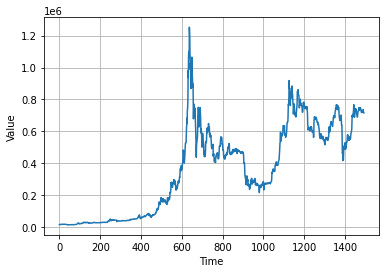

In [4]:
# Ploting the series
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


time = np.arange(len(series), dtype="float32")
plot_series(time, series)

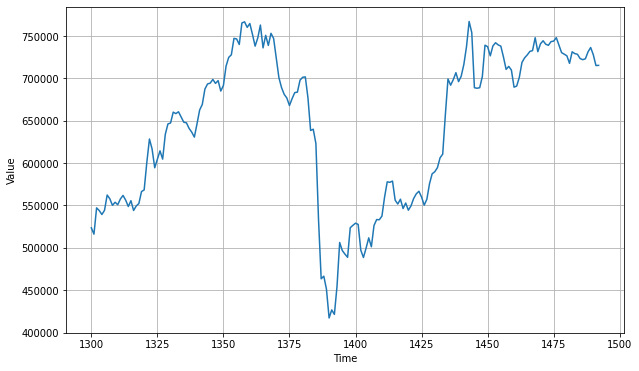

In [6]:
# Creating validation split for statistical analysis
split_time = 1300
time_train = time[: split_time]
x_train = series[: split_time]
time_val = time[split_time: ]
x_val = series[split_time: ]
plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plt.show()

# Basic Statistical Forecasting

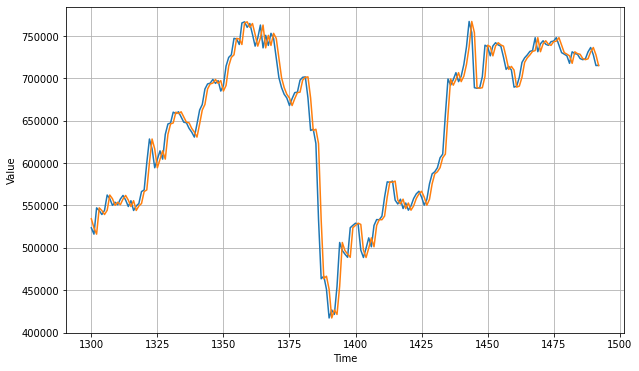

In [7]:
# Naive Forecasting
naive_forecast = series[split_time - 1: -1]
plt.figure(figsize = (10, 6))
plot_series(time_val, x_val)
plot_series(time_val, naive_forecast)

In [8]:
print(keras.metrics.mean_squared_error(x_val, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_val, naive_forecast).numpy())

281667687.22704244
11273.82868964968


In [9]:
# Moving average forecast
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time: time + window_size].mean())
  return np.array(forecast)

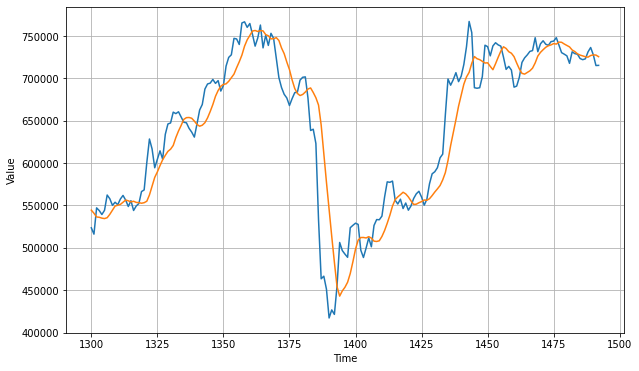

In [10]:
window = 7
moving_avg = moving_average_forecast(series, window)[split_time - window:]

plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, moving_avg)

In [12]:
print(keras.metrics.mean_squared_error(x_val, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_val, moving_avg).numpy())

1285389648.068837
24423.61578586192


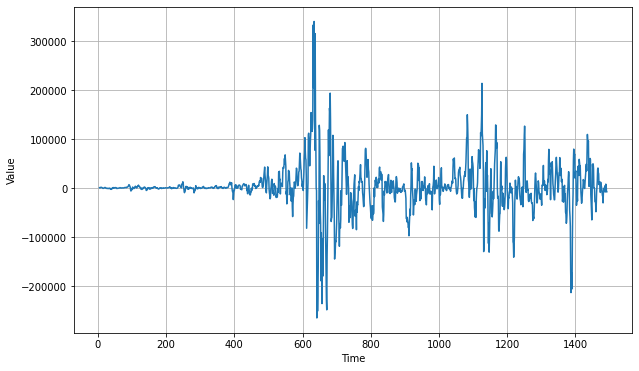

In [13]:
# create a differenced series
def difference(dataset, interval):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

interval = 5
diff_series = difference(series, interval)
diff_time = time[interval: ]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

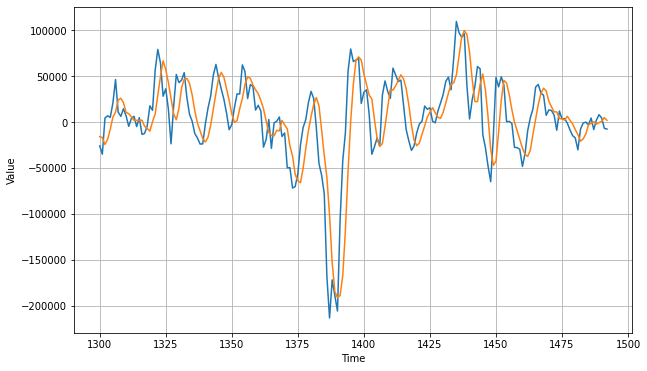

In [14]:
# Differenced moving averages
window = 3
diff_moving_avg = moving_average_forecast(diff_series, window)[split_time - interval - window:]

plt.figure(figsize=(10, 6))
plot_series(time_val, diff_series[split_time - interval:])
plot_series(time_val, diff_moving_avg)
plt.show()

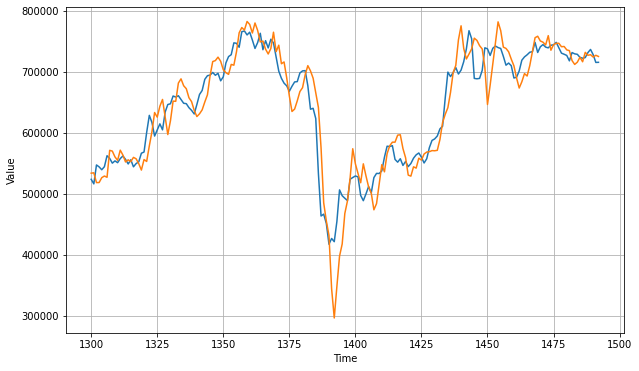

In [16]:
# Bring back the trend
diff_moving_avg_plus_past = series[split_time - interval: -interval] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_val, x_val)
plot_series(time_val, diff_moving_avg_plus_past)
plt.show()

In [17]:
print(keras.metrics.mean_squared_error(x_val, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_val, diff_moving_avg_plus_past).numpy())

1087336522.5701973
24221.054175714944


# Data Preprocessing

In [18]:
# Function to create windowed dataset
window_size = 30
def price_matrix_creator(data, seq_len = window_size):
    '''
    It converts the series into a nested list where every item of the list contains historic prices of 30 days
    '''
    price_matrix = []
    for index in range(len(data) - seq_len + 1):
        price_matrix.append(data[index : index + seq_len])
    return price_matrix

In [19]:
# Function to normalize the windowed dataset
def normalize_windows(window_data):
    '''
    It normalizes each value to reflect the percentage changes from starting point
    '''
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [25]:
price_matrix = price_matrix_creator(series)
price_matrix = normalize_windows(price_matrix)

In [31]:
# Function to split the dataset into train and validation set
def train_val_split(price_matrix, train_size = 0.9, shuffle = False, return_row = True):
    '''
    It makes a custom train test split where the last part is kept as the training set.
    '''
    price_matrix = np.array(price_matrix)
    print(price_matrix.shape)
    row = int(round(train_size * len(price_matrix)))
    train = price_matrix[:row, :]
    if shuffle  == True:
        np.random.shuffle(train)
    X_train, y_train = train[:row, :-1], train[:row, -1]
    X_val, y_val = price_matrix[row: , :-1], price_matrix[row: , -1]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    if return_row:
        return row, X_train, y_train, X_val, y_val
    else:
        return X_train, y_train, X_val, y_val

In [32]:
split_row, x_train, y_train, x_val, y_val = train_val_split(price_matrix, shuffle = True)

(1464, 30)


# Defining and Training the RNN

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
import time

In [88]:
# LSTM Model parameters
batch_size = 2           # Batch size
epochs = 20              # Epoch
seq_len = 30              # 30 sequence data (Representing the last 30 days)
loss='mean_squared_error' # Since the metric is MSE/RMSE
optimizer = tf.keras.optimizers.Adam(lr=1e-6)   # Recommended optimizer for RNN
activation = 'linear'     # Linear activation
input_shape=(None,1)      # Input dimension
output_dim = 30           # Output dimension

In [65]:
# Defining model and compiling it
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(units = output_dim, return_sequences = True, input_shape = input_shape))
model.add(Dense(units = 32, activation = activation))
model.add(LSTM(units = output_dim, return_sequences = False))
model.add(Dense(units = 1, activation = activation))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

model.compile(optimizer = optimizer, loss = loss, metrics = ['mae'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 30)          3840      
_________________________________________________________________
dense_2 (Dense)              (None, None, 32)          992       
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 12,423
Trainable params: 12,423
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the RNN
start_time = time.time()
history = model.fit(x = x_train,
          y = y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_split = 0.05,
          callbacks=[lr_schedule])
end_time = time.time()
processing_time = end_time - start_time

(1e-06, 0.01, 0.0, 0.03)

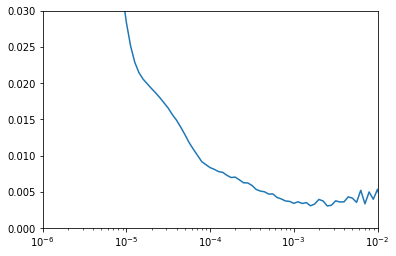

In [70]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-2, 0, 0.03])

In [90]:
# Training the RNN with optimal learning rate
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(units = output_dim, return_sequences = True, input_shape = input_shape))
model.add(Dense(units = 32, activation = activation))
model.add(LSTM(units = output_dim, return_sequences = False))
model.add(Dense(units = 1, activation = activation))

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.003), loss = loss, metrics = ['mae'])

In [91]:
# Training the RNN
start_time = time.time()
history = model.fit(x = x_train,
          y = y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_split = 0.05,
          )
end_time = time.time()
processing_time = end_time - start_time

Epoch 1/20
626/626 [==============================] - 11s 17ms/step - loss: 0.0129 - mae: 0.0689 - val_loss: 0.0026 - val_mae: 0.0343
Epoch 2/20
626/626 [==============================] - 10s 16ms/step - loss: 0.0055 - mae: 0.0470 - val_loss: 0.0044 - val_mae: 0.0441
Epoch 3/20
626/626 [==============================] - 10s 16ms/step - loss: 0.0049 - mae: 0.0443 - val_loss: 0.0021 - val_mae: 0.0337
Epoch 4/20
626/626 [==============================] - 10s 16ms/step - loss: 0.0043 - mae: 0.0419 - val_loss: 0.0017 - val_mae: 0.0254
Epoch 5/20
626/626 [==============================] - 10s 16ms/step - loss: 0.0039 - mae: 0.0409 - val_loss: 0.0024 - val_mae: 0.0312
Epoch 6/20
626/626 [==============================] - 10s 16ms/step - loss: 0.0041 - mae: 0.0414 - val_loss: 0.0038 - val_mae: 0.0506
Epoch 7/20
626/626 [==============================] - 10s 16ms/step - loss: 0.0041 - mae: 0.0408 - val_loss: 0.0030 - val_mae: 0.0356
Epoch 8/20
626/626 [==============================] - 10s 16ms

<Figure size 432x288 with 0 Axes>

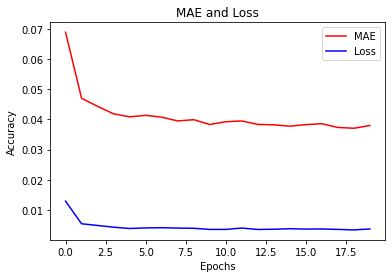

<Figure size 432x288 with 0 Axes>

In [92]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [52]:
# Saving the trained model
model.save('coin_predictor.h5')

In [ ]:
# Importing our trained RNN model
from tensorflow.keras.models import load_model
model = load_model('coin_predictor.h5')

# Making Predictions

In [93]:
#Predicting Test Set BTC Price and “Deserialize” It
preds = model.predict(x_val, batch_size = 2)

In [94]:
# Function to de-normalize the predicted values
def deserializer(preds, data, train_size = 0.9, train_phase = False):
    '''
    Arguments:
    preds : Predictions to be converted back to their original values
    data : It takes the data into account because the normalization was made based on the full historic data
    train_size : Only applicable when used in train_phase
    train_phase : When a train-test split is made, this should be set to True so that a cut point (row) is calculated based on the train_size argument, otherwise cut point is set to 0
    
    Returns:
    A list of deserialized prediction values, original true values, and date values for plotting
    '''
    price_matrix = price_matrix_creator(series)
    price_matrix = np.array(price_matrix)
    if train_phase:
        row = int(round(train_size * len(price_matrix)))
    else:
        row = 0
    date = series.index[row + 29:]
    date = np.reshape(date, (date.shape[0]))
    X_test = price_matrix[row:, :-1]
    y_test = price_matrix[row:, -1]
    preds_original = []
    preds = np.reshape(preds, (preds.shape[0]))
    for index in range(0, len(preds)):
        pred = (preds[index] + 1) * X_test[index][0]
        preds_original.append(pred)
    preds_original = np.array(preds_original)
    if train_phase:
        return [date, y_test, preds_original]
    else:
        import datetime
        return[date + datetime.timedelta(days = 1), y_test]

In [95]:
# Real Predictions
real_preds = deserializer(preds, series, train_phase = True)

In [96]:
predicted = pd.Series(real_preds[1])
real_prices = pd.Series(real_preds[2])

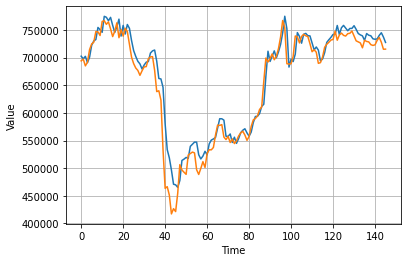

In [97]:
time = np.arange(146, dtype="float32")
plot_series(time, real_prices)
plot_series(time, predicted)
plt.show()

In [98]:
print(keras.metrics.mean_squared_error(real_prices, predicted).numpy())
print(keras.metrics.mean_absolute_error(real_prices, predicted).numpy())

606959424.4001918
16424.997498940687
